In [1]:
import os
import json
import csv
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2 as cv
#from utils import *
from triplet_utils import *
import random
random.seed(100)
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import pickle

In [2]:
with open(os.path.join(data_path, "2DInstances.txt")) as f:
            reader = csv.reader(f, delimiter='\t')
            next(reader)
            instances = [i for i in reader]

In [3]:
nb_instances = len(instances)
print(f"Number of instances: {nb_instances}")

Number of instances: 1970


In [4]:
len(instances[0])

31

## Example

In [5]:
my_instance = instances[100]

In [6]:
parse_instance(my_instance)

{'reference': '',
 'scan': '0ad2d382-79e2-2212-98b3-641bf9d552c1',
 'frame_nr': 197,
 'instance_id': 10,
 'label': 'table',
 'bbox': [172, 0, 906, 539],
 'visibility': [55405.0, 74616.0, 0.742535, 221451.0, 235611.0, 0.939901],
 'number_other_instances': 5,
 'other_instance_ids': [4, 5, 6, 11, 39],
 'other_bboxes': [[0, 0, 323, 184],
  [0, 57, 127, 539],
  [8, 150, 259, 539],
  [116, 185, 208, 328],
  [584, 93, 785, 380]]}

In [7]:
my_loaded_instance = load_instance(my_instance, transform)
my_loaded_instance

{'image': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 'bbox': {'x': 48, 'y': 39, 'w': 127, 'h': 173},
 'label': 'table',
 'instance_id': 10,
 'reference': '',
 'scan': '0ad2d382-79e2-2212-98b3-641bf9d552c1',
 'frame_nr': 197}

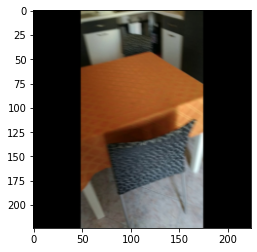

In [8]:
plt.imshow(my_loaded_instance["image"].permute(1,2,0).numpy())
plt.show()

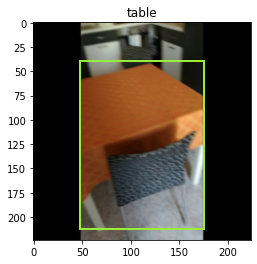

In [9]:
import matplotlib.patches as patches

fig, ax = plt.subplots(1)
plt.title(my_loaded_instance["label"])
ax.imshow(my_loaded_instance["image"].permute(1,2,0).numpy())
bbox = my_loaded_instance["bbox"]
x = bbox["x"]
y = bbox["y"]
width = bbox["w"]
height = bbox["h"]
rect = patches.Rectangle((x, y), width, height,
                         linewidth=2, edgecolor=np.random.rand(3,), facecolor='none')
ax.add_patch(rect)
plt.show()

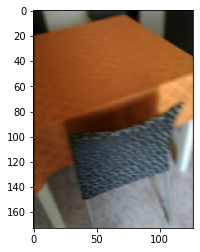

In [10]:
image_crop = my_loaded_instance["image"][:, y:y+height, x:x+width]
plt.imshow(image_crop.permute(1,2,0).numpy())
plt.show()

## Triplets

In [11]:
# A commenter après la première exécution

triplets_possibilities = {}

for idx in tqdm(range(len(instances))):
    
    anchor = instances[idx]
    
    all_possible_positives, all_possible_negatives, triplet_found = find_triplet(anchor, instances)

    triplets_possibilities[str(anchor)] = {
        "pos": all_possible_positives,
        "neg": all_possible_negatives
    }

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1970/1970 [06:33<00:00,  5.00it/s]


In [12]:
# A commenter après la première exécution

with open("saved_dict/triplets_possibilities.pkl", "wb") as f:
    pickle.dump(triplets_possibilities, f)

In [13]:
with open("saved_dict/triplets_possibilities.pkl", "rb") as f:
    triplets_possibilities = pickle.load(f)

In [14]:
len(triplets_possibilities)

1970

In [15]:
len(triplets_possibilities[str(instances[0])]['pos'])

4

In [16]:
len(triplets_possibilities[str(instances[0])]['neg'])

5

In [17]:
len(triplets_possibilities[str(instances[0])]["pos"][0])

5

In [18]:
len(triplets_possibilities[str(instances[10])]["neg"][0])

20

In [19]:
triplets_possibilities[str(instances[10])]["neg"][0][0]

['',
 '0a4b8ef6-a83a-21f2-8672-dce34dd0d7ca',
 '000333',
 '17',
 'bed',
 '12',
 '305',
 '959',
 '531',
 '23094',
 '38251',
 '0.603749',
 '93150',
 '135878',
 '0.685541',
 '0']

In [20]:
anchors = []
positives = []
negatives = []
removed_idx = []
triplet_dict = {}

for idx in tqdm(range(len(instances))):
    anchor = instances[idx]
    pos = triplets_possibilities[str(anchor)]["pos"]
    neg = triplets_possibilities[str(anchor)]["neg"]
    valid, positive, negative = sample_triplets(pos, neg)

    if valid:
        # these lists are for the idx-based iteration of torch.util.dataset
        anchors.append(anchor)
        positives.append(positive)
        negatives.append(negative)

        # this allows an O(1) access to a triplet by its key
        triplet_dict[str(anchor)] = {
            "anchor": anchor,
            "pos": positive,
            "neg": negative
        }
    else:
        removed_idx.append(idx)

# remove all instances for which we could not find a valid triplet
instances = [i for idx, i in enumerate(instances) if idx not in removed_idx]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 1970/1970 [00:01<00:00, 1312.00it/s]


In [21]:
len(triplet_dict)

469

In [22]:
len(anchors)

469

In [23]:
len(positives)

469

In [24]:
len(negatives)

469

In [25]:
def get_triplet(idx):

    anchor = load_instance(anchors[idx], transform)
    p = load_instance(positives[idx], transform)
    n = [load_instance(neg, transform) for neg in negatives[idx]]

    return {
        "anchor": anchor,
        "pos": p,
        "neg": n
    }

In [26]:
get_triplet(0)

{'anchor': {'image': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
  
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
  
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]),
  'bbox': {'x': 75, 'y': 92, 'w': 97, 'h': 91},
  'label': 'pillow',
  'instance_id': 28,
  'reference': '',
  'scan': '0a4b8ef6-a83a-21f2-8672-dce3

In [49]:
i = 50

item = get_triplet(i)
anchor = parse_instance(anchors[i])
pos = parse_instance(positives[i])
neg = parse_instance(negatives[i][0])

print("ANCHOR STATISTICS: ")
print(json.dumps(anchor, indent=4, sort_keys=False))

print("POS STATISTICS: ")
print(json.dumps(pos, indent=4, sort_keys=False))

print("NEG STATISTICS: ")
print(json.dumps(neg, indent=4, sort_keys=False))

ANCHOR STATISTICS: 
{
    "reference": "",
    "scan": "0ad2d391-79e2-2212-98a3-7e2440884395",
    "frame_nr": 34,
    "instance_id": 8,
    "label": "chair",
    "bbox": [
        19,
        50,
        959,
        539
    ],
    "visibility": [
        61117.0,
        83798.0,
        0.729337,
        245978.0,
        245978.0,
        1.0
    ],
    "number_other_instances": 3,
    "other_instance_ids": [
        2,
        7,
        12
    ],
    "other_bboxes": [
        [
            636,
            498,
            959,
            539
        ],
        [
            0,
            0,
            474,
            308
        ],
        [
            355,
            0,
            538,
            66
        ]
    ]
}
POS STATISTICS: 
{
    "reference": "",
    "scan": "0ad2d38f-79e2-2212-98d2-9b5060e5e9b5",
    "frame_nr": 101,
    "instance_id": 8,
    "label": "chair",
    "bbox": [
        0,
        110,
        696,
        539
    ],
    "visibility": [
        42

chair


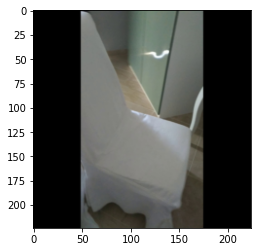

chair


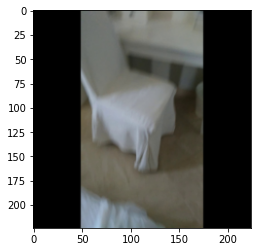

wardrobe


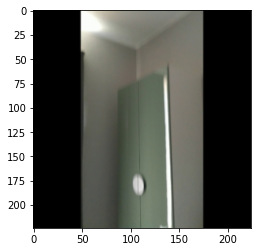

In [50]:
plt.imshow(item["anchor"]["image"].permute(1,2,0).numpy())
print(item["anchor"]["label"])
plt.show()

plt.imshow(item["pos"]["image"].permute(1,2,0).numpy())
print(item["pos"]["label"])
plt.show()

plt.imshow(item["neg"][0]["image"].permute(1,2,0).numpy())
print(item["neg"][0]["label"])
plt.show()

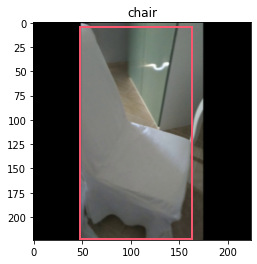

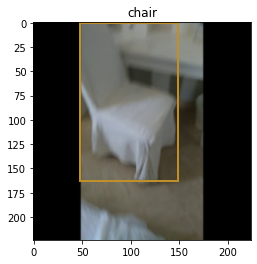

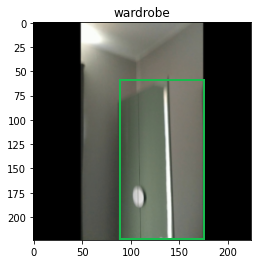

In [51]:
images = [item["anchor"]["image"], item["pos"]["image"], item["neg"][0]["image"]]
labels = [item["anchor"]["label"], item["pos"]["label"], item["neg"][0]["label"]]
bboxes = [item["anchor"]["bbox"], item["pos"]["bbox"], item["neg"][0]["bbox"]]

for image, label, bbox in zip(images, labels, bboxes):
    fig,ax = plt.subplots(1)
    plt.title(label)
    ax.imshow(image.permute(1,2,0).numpy())

    x = bbox["x"]
    y = bbox["y"]
    width = bbox["w"]
    height = bbox["h"]
    rect = patches.Rectangle((x, y),
                            width,
                            height,
                            linewidth=2, edgecolor=np.random.rand(3,), facecolor='none')
    ax.add_patch(rect)
    plt.show()

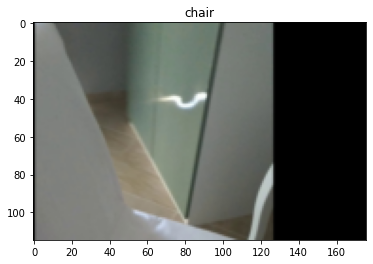

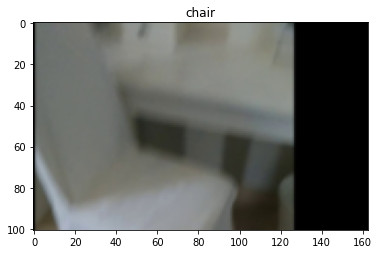

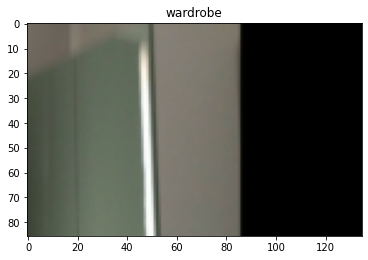

In [52]:
images = [item["anchor"]["image"], item["pos"]["image"], item["neg"][0]["image"]]
labels = [item["anchor"]["label"], item["pos"]["label"], item["neg"][0]["label"]]
bboxes = [item["anchor"]["bbox"], item["pos"]["bbox"], item["neg"][0]["bbox"]]

for image, label, bbox in zip(images, labels, bboxes):
    fig,ax = plt.subplots(1)
    plt.title(label)

    x = bbox["x"]
    y = bbox["y"]
    w = bbox["w"]
    h = bbox["h"]
    image_crop = image[:, y:y+w, x:x+h]
    ax.imshow(image_crop.permute(1,2,0).numpy())
    plt.show()

In [31]:
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [32]:
import torch.utils.data

class TripletDataset(torch.utils.data.Dataset):
    def __init__(self, anchors, positives, negatives, transform=None):
        self.transform = transform
        self.anchors = anchors
        self.positives = positives
        self.negatives = negatives
        self.size = len(self.anchors)

    def __getitem__(self, idx):
        anchor = load_instance(self.anchors[idx], transform)
        p = load_instance(self.positives[idx], transform)
        n = [load_instance(neg, transform) for neg in self.negatives[idx]]

        return {
            "anchor": anchor,
            "pos": p,
            "neg": n
        }

    def __len__(self):
        return self.size

In [33]:
anchors

[['',
  '0a4b8ef6-a83a-21f2-8672-dce34dd0d7ca',
  '000234',
  '28',
  'pillow',
  '397',
  '14',
  '784',
  '425',
  '20298',
  '20298',
  '1',
  '81208',
  '81208',
  '1',
  '4',
  '17',
  '441',
  '0',
  '959',
  '539',
  '27',
  '247',
  '0',
  '498',
  '89',
  '29',
  '382',
  '82',
  '767',
  '493',
  '30',
  '267',
  '172',
  '642',
  '539'],
 ['',
  '0a4b8ef6-a83a-21f2-8672-dce34dd0d7ca',
  '000289',
  '28',
  'pillow',
  '0',
  '0',
  '493',
  '539',
  '44453',
  '50452',
  '0.881095',
  '174173',
  '174173',
  '1',
  '3',
  '17',
  '0',
  '0',
  '959',
  '539',
  '27',
  '0',
  '0',
  '8',
  '41',
  '29',
  '0',
  '46',
  '471',
  '539'],
 ['',
  '0a4b8ef6-a83a-21f2-8672-dce34dd0d7ca',
  '000288',
  '28',
  'pillow',
  '0',
  '31',
  '616',
  '539',
  '48770',
  '52678',
  '0.925813',
  '195116',
  '195118',
  '0.99999',
  '5',
  '17',
  '26',
  '0',
  '959',
  '539',
  '26',
  '0',
  '0',
  '118',
  '24',
  '27',
  '0',
  '12',
  '111',
  '125',
  '29',
  '0',
  '123',
  '591

In [34]:
dataset = TripletDataset(anchors, positives, negatives, transform)

In [35]:
dataset.size

469

In [36]:
len(dataset.anchors)

469

In [37]:
from torch.utils.data.sampler import SubsetRandomSampler, SequentialSampler

In [38]:
batch_size = 64
validation_percentage = 0.2
shuffle_dataset = True
random_seed = 42
#num_workers = 2

dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_percentage * dataset_size))
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset,
                                           batch_size=batch_size,
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(dataset,
                                         batch_size=batch_size,
                                         sampler=val_sampler)

In [39]:
next(iter(val_loader))

{'anchor': {'image': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]],
  
           [[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]],
  
           [[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0.,